#####  NoMnist preprocessing 

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from os import listdir
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage, misc
import imageio 
import skimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

last_percent_reorted = None

def download_progress_hook(count, blocksize, totalsize):
    
    global last_percent_reorted
    percent = int(count*blocksize*100/totalsize)
    
    if last_percent_reorted != percent : 
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent 
    

In [3]:
########### function for download file

def maybe_download(filename, expected_bytes, force= True): 
    if force or not os.path.exists(filename):
        print("Attempting to download:", filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook= download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)    
    if statinfo.st_size == expected_bytes :
        print('found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')       
    return filename
        

In [4]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz


0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%............................................................................................................................................................................................................................................................................................................................................................................................................

40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%...............................................................................................................................................................................

###### Extract the dataset from the compressed .tar.gz file

In [5]:
num_classes = 10
np.random.seed(133)
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force :
        print('%s Already present - skipping extracting of %s.'% (root,filename))
    else : 
        print('extracting data from %s. This may take a while. Please wait.'% root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root,d)  for d in sorted(os.listdir(root))
                   if os.path.isdir(os.path.join(root,d))]    
    if len(data_folders) != num_classes :
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.'%(num_classes,len(data_folders) ))        
    print(data_folders)
    return data_folders

In [6]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large Already present - skipping extracting of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small Already present - skipping extracting of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


In [7]:
### Display a sample of the images that we just downloaded

Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png")

Image(filename='notMNIST_large/A/a2F6b28udHRm.png')





In [8]:
len(train_folders)

10

In [9]:
##### Get all filename 

fn = os.listdir("notMNIST_small/A/")
print(len(fn))
essaies = fn [:2]
essaies

 

1873


['MDEtMDEtMDAudHRm.png', 'MDRiXzA4LnR0Zg==.png']

In [10]:
tb = []
for image in essaies  : 
    path = os.path.join("notMNIST_small/A/", image)
    statfile = os.stat(path)
    filesize = statfile.st_size
    #print(filesize) 
    if filesize != 0:
        tb.append(image)
tb

['MDEtMDEtMDAudHRm.png', 'MDRiXzA4LnR0Zg==.png']

In [11]:
FL = os.listdir( 'notMNIST_large/A/')
print(len(FL))
FL[:5]

52912


['a29ydW5pc2hpLnR0Zg==.png',
 'a2F6b28udHRm.png',
 'a2FkZW4udHRm.png',
 'a2FpcmVlLnR0Zg==.png',
 'a2Fua2FuYSBLLnR0Zg==.png']

In [12]:
#  Test if  data_FL[:num,:,:] = imput_data work well 
FL_test = FL[:2]
data_FL = np.ndarray(shape = (len(FL_test),28,28))
num =0
for k in FL_test :
    path = os.path.join('notMNIST_large/A/',k)
    imput_data = imageio.imread(path)
    data_FL[num,:,:] = imput_data
    num+=1
data_FL = data_FL[:num, :,]
data_FL.shape

(2, 28, 28)

In [13]:
'''data = np.zeros((1,2,2))
data 
'''

'data = np.zeros((1,2,2))\ndata \n'

In [14]:
'''
data1 = np.ones((2,2))
print(data1)
data[0:1,:,:]=data1
'''

'\ndata1 = np.ones((2,2))\nprint(data1)\ndata[0:1,:,:]=data1\n'

In [15]:
#### test imageio.shape 
for file in FL[:2]:
    path = 'notMNIST_large/A/' + file
    print(imageio.imread(path).shape)
    

(28, 28)
(28, 28)


In [16]:
# Display first 2 images  
for file in fn[:2]:
    path =  'notMNIST_small/A/' + file
    display(Image(path))
    

In [18]:
### Testing to eliminate bad files
tb = []
for image in FL[:3]  : 
    path = os.path.join("notMNIST_large/A/", image)
    statfile = os.stat(path)
    filesize = statfile.st_size
    #print(filesize) 
    if filesize != 0:
        tb.append(image)
tb 
    

['a29ydW5pc2hpLnR0Zg==.png', 'a2F6b28udHRm.png', 'a2FkZW4udHRm.png']

In [19]:
#### check extention on file 

tab = []
for image in FL:
    path = os.path.join("notMNIST_large/B/", image)
    statfile = os.stat(path)
    filesize = statfile.st_size    
    if filesize != 0  and  path.endswith('.png'):        
        tab.append(image)
        
tab
    

['a29ydW5pc2hpLnR0Zg==.png',
 'a2F6b28udHRm.png',
 'a2FkZW4udHRm.png',
 'a2FpcmVlLnR0Zg==.png',
 'a2Fua2FuYSBLLnR0Zg==.png',
 'a2FuIEUudHRm.png',
 'a2hhcm9uNGFfbWluaS50dGY=.png',
 'a2l0Y2hlbiB0aWxlLnR0Zg==.png',
 'a2ltaWRvcmkgbXVnY3VwLnR0Zg==.png',
 'a2VhZ2FuLnR0Zg==.png',
 'a2VtaWthbEhpLnR0Zg==.png',
 'a2xvenpiYXRzLnR0Zg==.png',
 'a3JvZWdlciAwNF81Ni50dGY=.png',
 'a3JvZWdlciAwNF81NS50dGY=.png',
 'a3JvZWdlciAwNF82Ni50dGY=.png',
 'a3JvZWdlciAwNF82NS50dGY=.png',
 'a3JvZWdlciAwNl81Ni50dGY=.png',
 'a3JvZWdlciAwNl81NS50dGY=.png',
 'a3JvZWdlciAwNl82My50dGY=.png',
 'a3JvZWdlciAwNl82NC50dGY=.png',
 'a3JvZWdlciAwNl82Ni50dGY=.png',
 'a3JvZWdlciAwNl82NS50dGY=.png',
 'a3JvZWdlciAwNV81My50dGY=.png',
 'a3JvZWdlciAwNV81NC50dGY=.png',
 'a3JvZWdlciAwNV81Ni50dGY=.png',
 'a3JvZWdlciAwNV81NS50dGY=.png',
 'a3JvZWdlciAwNV81Ny50dGY=.png',
 'a3JvZWdlciAwNV81OC50dGY=.png',
 'a3JvZWdlciAwNV82My50dGY=.png',
 'a3JvZWdlciAwNV82NC50dGY=.png',
 'a3JvZWdlciAwNV82Ni50dGY=.png',
 'a3JvZWdlciAwNV82NS50dGY=.png',
 'aG9tZW

In [21]:
image_size = 28
pixel_depth = 255.0
def load_folder(folder, min_num_image):      
    images_files = os.listdir(folder)   
    N_images_files = []    
    for check in images_files : 
        path = os.path.join(folder, check)
        statfile = os.stat(path)
        filesize = statfile.st_size
        if path.endswith('.png') and  filesize != 0:
            N_images_files.append(check)   
    dataset = np.ndarray(shape = (len(N_images_files),image_size ,image_size))
    num_image = 0
    for image in N_images_files:
        image_file = os.path.join(folder, image)
        try : 
            image_data = (imageio.imread(image_file)- pixel_depth / 2)/ pixel_depth
            if image_data.shape != (image_size,image_size) :
                raise Exception ("unexcepted image shape : %s"% str(image_data.shape))
            dataset[:num_image, :, : ] =  image_data
            num_image +=1
        except (IOError,ValueError) as e :
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')   
    dataset = dataset[:num_image, :, :]
    if num_image < min_num_image :
        raise Exception ( "Many fewer images than expected: %d < %d' %"%
                         (num_image, min_num_image ))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))  
    return dataset

In [22]:
### Test of load_folders funtion 
'''
folders = 'notMNIST_large\\A'
load_folder (folders,4)

'''

"\nfolders = 'notMNIST_large\\A'\nload_folder (folders,4)\n\n"

In [23]:
def maybe_pickle(data_folders, min_num_images_per_class, force = True): 
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            print("%s already exist, skipping pickling"%set_filename)
        else:
            print("Pickling %s"% set_filename)
            dataset = load_folder(folder,min_num_images_per_class) 
        try:
            with open(set_filename, 'wb') as f :
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e :
            print('Unable to save data to', set_filename, ':', e)
            
    return dataset_names

In [24]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


Pickling notMNIST_large\A.pickle
Could not read: notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.06789587558170602
Standard deviation: 0.4658310081063711
Pickling notMNIST_large\B.pickle
Full dataset tensor: (52911, 28, 28)
Mean: 0.1282138632701662
Standard deviation: 0.44837227282553915
Pickling notMNIST_large\C.pickle
Full dataset tensor: (52912, 28, 28)
Mean: -0.09233018776379609
Standard deviation: 0.45931146492627556
Pickling notMNIST_large\D.pickle
Full dataset tensor: (52911, 28, 28)
Mean: 0.013400106881784352
Standard deviation: 0.465766589405017
Pickling notMNIST_large\E.pickle
Full dataset tensor: (52912, 28, 28)
Mean: -0.01159942063081648
Standard deviation: 0.4683193064436965
Pickling notMNIST_large\F.pickle
Full dataset tensor: (52912, 28, 28)
Mean: -0.10745095040586372
Standard deviation: 0.4604875261902066
Pickling notMNIST_large\G

In [ ]:
for labels, pic in enumerate (train_datasets):
    print(labels, pic)

0 notMNIST_large\A.pickle
1 notMNIST_large\B.pickle
2 notMNIST_large\C.pickle
3 notMNIST_large\D.pickle
4 notMNIST_large\E.pickle
5 notMNIST_large\F.pickle
6 notMNIST_large\G.pickle
7 notMNIST_large\H.pickle
8 notMNIST_large\I.pickle
9 notMNIST_large\J.pickle


In [44]:
picklefile = train_datasets[1]
picklefile

'notMNIST_large\\B.pickle'

In [45]:
os.path.getsize(picklefile)

331857958

38428


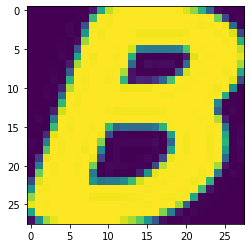

In [46]:
#### Open file 
with open(picklefile, 'rb') as f :
    ### unpickle file 
    letters_set = pickle.load(f)
    # pick a random image index
    index_pick = np.random.randint(len(letters_set))
    print(index_pick)
    sample_img =  letters_set[index_pick, :, :]
    #print(letters_set)
    plt.figure()
    plt.imshow(sample_img)
    
        

In [47]:
##### Merge data and create the valid dataset 

#### make array of training X and Y
def make_array(nbrows, images_size):
    if nbrows:
        dataset = np.ndarray(shape =(nbrows, images_size, images_size), dtype = np.float32)
        labels = np.ndarray(nbrows, dtype = np.int32)
    else:
        dataset, labels = None, None
        
    return dataset, labels


In [48]:
def merge_data (pickle_files, train_size, valid_size = 0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_array(valid_size, image_size)
    train_dataset, train_labels = make_array(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size// num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l  = vsize_per_class + tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f : 
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None :
                    valid_letters = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letters
                    valid_labels [start_v:end_v]= label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                
                train_letters = letter_set [: tsize_per_class, : , :]
                train_dataset[start_t:end_t, : , : ] = train_letters
                train_labels [start_t:end_t] = label 
                start_t += tsize_per_class
                end_t += tsize_per_class 
        except Exception as e : 
            print('Unable to process data from', pickle_file, ':', e)
            raise
                
    return valid_dataset, valid_labels, train_dataset,train_labels
            
                
                    
                    


In [49]:
train_size = 200000
valid_size =  10000
test_size = 10000
valid_dataset, valid_labels, train_dataset, train_labels = merge_data(
train_datasets, train_size, valid_size)


In [50]:
_, _, test_dataset, test_labels = merge_data(test_datasets, test_size)

In [51]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [52]:
valid_labels.shape[0]

10000

In [53]:
#### randomize the data

def randomize ( dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,: , : ]
    shuffled_labels  = labels [permutation]
    
    return shuffled_dataset, shuffled_labels
    

In [62]:
Train_dataset, Train_labels = randomize(train_dataset, train_labels)

In [63]:
train_dataset.shape

(200000, 28, 28)

In [64]:
Valid_dataset, Valid_labels = randomize(valid_dataset, valid_labels)

In [65]:
Valid_dataset.shape

(10000, 28, 28)

In [66]:
Test_dataset,Test_labels = randomize(test_dataset, test_labels)

In [67]:
Test_dataset.shape 

(10000, 28, 28)

In [72]:
####### Save the data for later reuse

pickle_file = 'notMNIST.pickle'

try : 
    f = open(pickle_file, 'wb')
    save = {
        "Train_dataset" : Train_dataset,
        "Train_labels"  : Train_labels ,
        "Valid_dataset" : Valid_dataset,
        "Valid_labels"  : Valid_labels,
        "Test_dataset"  : Test_dataset,
        "Test_labels"   : Test_labels 
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    
    f.close()
    
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [73]:
# Getting statistics of a file using os.stat(file_name)

statinfo = os.stat(pickle_file)

print("compressed pickle dataset", statinfo.st_size)

compressed pickle dataset 690800506
